In [1]:
import numpy as np
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import os
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch.nn as nn
from tqdm import tqdm, trange
import time
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, cohen_kappa_score
from efficientnet_pytorch import EfficientNet
import cv2
import pandas as pd

In [2]:
seed = 42
torch.cuda.get_device_name()

'Tesla T4'

In [12]:
labels = pd.read_csv("../input/training-labels.csv")

In [13]:
labels.groupby(['Drscore']).size()

Drscore
0    11651
1     1397
2     3299
3      841
4      619
dtype: int64

In [14]:
train_df, val_df = train_test_split(labels, test_size=0.2,stratify=labels['Drscore'], random_state = seed)

In [15]:
BATCH_SIZE = 2**4
NUM_WORKERS = 4
LEARNING_RATE = 5e-5
NUM_EPOCHS = 15
LOG_FREQ = 50
TIME_LIMIT = 8 * 60 * 60
RESIZE = 512
torch.cuda.empty_cache()

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# classes

In [ ]:
class OR_CNN(nn.Module):
    def __init__(self, rater_ids:list=None):
        super(OR_CNN, self).__init__()
        self.en = EfficientNet.from_pretrained('efficientnet-b4', num_classes=8)
        self.personalized_layers = nn.ModuleList()
        for id in rater_ids:
            self.personalized_layers.append(nn.Linear(512, 1))
            self.personalized_layers[-1].requires_grad = False        
        self.resnet_fc = nn.Linear(512, 1)
        self.rater_id_mapping = dict(zip(rater_ids, range(len(rater_ids))))

    def forward(self, x, rater_id = None):
        if rater_id:
            x = self.resnet(x)
            id = self.rater_id_mapping[rater_id]
            personal_adj = self.personalized_layers[id](x)
            return self.resnet_fc(x) + personal_adj
        else:
            return self.resnet_fc(self.resnet(x))
        
        return x

In [29]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, mode):
        assert mode in ['train', 'val', 'test']

        self.df = dataframe
        self.mode = mode

        transforms_list = [
            transforms.Resize(RESIZE),
            transforms.CenterCrop(RESIZE)
        ]

        if self.mode == 'train':
            transforms_list.extend([
                transforms.RandomHorizontalFlip(),
                transforms.RandomChoice([
                    transforms.RandomAffine(degrees=(0,180), translate=(0.1, 0.1),
                                            scale=(0.9, 1.1))
                ])
            ])

        transforms_list.extend([
            transforms.ToTensor(),
            #             transforms.Normalize(mean=[0.485, 0.456, 0.406],
            #                                   std=[0.229, 0.224, 0.225]),
        ])
        self.transforms = transforms.Compose(transforms_list)

    def __getitem__(self, index):
        ''' Returns: tuple (sample, target) '''
        filename = self.df['Filename'].values[index]

        directory = '../input/Test' if self.mode == 'test' else '../input/output_combined2'
        sample = Image.open(f'./{directory}/gb_{filename}')
        image = self.transforms(sample)

        if self.mode == 'test':
            return image
        else:
            return image, self.df['Drscore'].values[index]

    def scaleRadius(self, img, scale):
        x = img[img.shape[0]//2,:,:].sum(1)
        r = (x > x.mean() / 10).sum() / 2
        s = scale * 1.0 / r
        return cv2.resize(img, (0, 0), fx=s, fy=s)

    def __len__(self):
        return self.df.shape[0]

In [30]:
def GAP(predicts: torch.Tensor, confs: torch.Tensor, targets: torch.Tensor):
    ''' Simplified GAP@1 metric: only one prediction per sample is supported '''
    assert len(predicts.shape) == 1
    assert len(confs.shape) == 1
    assert len(targets.shape) == 1
    assert predicts.shape == confs.shape and confs.shape == targets.shape

    confs = confs.cpu().numpy()
    predicts = predicts.cpu().numpy()
    targets = targets.cpu().numpy()

    res = accuracy_score(targets, predicts)
    return res

In [31]:
class AverageMeter:
    ''' Computes and stores the average and current value '''
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0.0
        self.avg = 0.0
        self.sum = 0.0
        self.count = 0

    def update(self, val, n = 1) :
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


In [32]:
def train(train_loader, model, criterion, optimizer, epoch, logging = True):
    batch_time = AverageMeter()
    losses = AverageMeter()
    avg_score = AverageMeter()

    model.train()
    num_steps = len(train_loader)

    end = time.time()
    lr_str = ''

    for i, (input_, target) in enumerate(train_loader):
        if i >= num_steps:
            break

        output = model(input_.to(device))
        loss = criterion(output, target.to(device))

        confs, predicts = torch.max(output.detach(), dim=1)
        avg_score.update(GAP(predicts, confs, target))

        losses.update(loss.data.item(), input_.size(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_time.update(time.time() - end)
        end = time.time()

        if logging and i % LOG_FREQ == 0:
            print(f'{epoch} [{i}/{num_steps}]\t'
                        f'time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                        f'loss {losses.val:.4f} ({losses.avg:.4f})\t'
                        f'GAP {avg_score.val:.4f} ({avg_score.avg:.4f})'
                        + lr_str)
        if has_time_run_out():
            break

    print(f' * average GAP on train {avg_score.avg:.4f}')
    return avg_score.avg

In [33]:
def inference(data_loader, model):
    ''' Returns predictions and targets, if any. '''
    model.eval()

    activation = nn.Softmax(dim=1)
    all_predicts, all_confs, all_targets = [], [], []

    with torch.no_grad():
        for i, data in enumerate(data_loader):
            if data_loader.dataset.mode != 'test':
                input_, target = data
            else:
                input_, target = data, None

            output = model(input_.to(device))
            output = activation(output)

            confs, predicts = torch.topk(output, 1)
            all_confs.append(confs)
            all_predicts.append(predicts)

            if target is not None:
                all_targets.append(target)

    predicts = torch.cat(all_predicts)
    confs = torch.cat(all_confs)
    targets = torch.cat(all_targets) if len(all_targets) else None

    return predicts, confs, targets

In [34]:
def test(test_loader, model):
    predicts, confs, targets = inference(test_loader, model)
    predicts = predicts.cpu().numpy().flatten()
    targets = targets.cpu().numpy().flatten()
    return cohen_kappa_score(targets, predicts)

In [35]:
def train_loop(epochs, train_loader, test_loader, model, criterion, optimizer, 
               validate=True):
    train_res = []

    test_res = []
    for epoch in trange(1, epochs + 1):
        start_time = time.time()
        train_acc = train(train_loader, model, criterion, optimizer, epoch, logging=True)
        if has_time_run_out():
            break
        train_res.append(train_acc)

        if validate:
            test_acc = test(test_loader, model)
            test_res.append(test_acc)
            print(f"validation score: {test_acc}")
            
    return train_res, test_res

In [36]:
def generate_submission(test_loader, model, label_encoder):
    sample_sub = pd.read_csv('../SampleSubmission.csv')

    predicts_gpu, confs_gpu, _ = inference(test_loader, model)
    predicts, confs = predicts_gpu.cpu().numpy(), confs_gpu.cpu().numpy()

    labels = [label_encoder.inverse_transform(pred) for pred in predicts]
    print('labels')
    print(np.array(labels))
    print('confs')
    print(np.array(confs))

    sub = test_loader.dataset.df
    def concat(label: np.ndarray, conf: np.ndarray) -> str:
        return ' '.join([f'{L} {c}' for L, c in zip(label, conf)])
    sub['landmarks'] = [concat(label, conf) for label, conf in zip(labels, confs)]

    sample_sub = sample_sub.set_index('id')
    sub = sub.set_index('id')
    sample_sub.update(sub)

    sample_sub.to_csv('submission.csv')

In [37]:
def has_time_run_out() -> bool:
    return time.time() - global_start_time > TIME_LIMIT - 1000

# model

In [38]:
train_dataset = ImageDataset(train_df, mode='train')
val_dataset = ImageDataset(val_df, mode='val')
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                          drop_last=True, num_workers=NUM_WORKERS)

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=NUM_WORKERS)

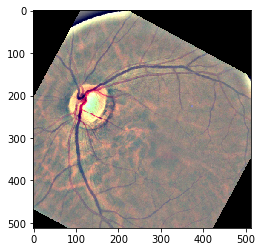

In [39]:
plt.imshow(train_dataset[300][0].permute(1, 2, 0))

In [19]:
model = EfficientNet.from_pretrained('efficientnet-b4', num_classes=5)

Loaded pretrained weights for efficientnet-b4


In [20]:
# model.load_state_dict(torch.load("./model/efficientnet_os.ptm"))

In [21]:
model = model.to(device)
model = nn.DataParallel(model)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
global_start_time = time.time()
train_res, test_res = train_loop(NUM_EPOCHS, train_loader, val_loader, model, criterion, optimizer)

In [27]:
predicts, confs, targets = inference(val_loader, model)

In [28]:
print(classification_report(targets.cpu(), predicts.cpu()))

              precision    recall  f1-score   support

           0       0.85      0.94      0.89      1969
           1       0.20      0.12      0.15       205
           2       0.64      0.47      0.54       460
           3       0.56      0.61      0.58       130
           4       0.66      0.57      0.61        65

   micro avg       0.78      0.78      0.78      2829
   macro avg       0.58      0.54      0.56      2829
weighted avg       0.75      0.78      0.76      2829



In [29]:
confusion_matrix(targets.cpu(), predicts.cpu())

array([[1852,   61,   49,    4,    3],
       [ 152,   25,   25,    3,    0],
       [ 153,   35,  216,   50,    6],
       [   6,    3,   32,   79,   10],
       [   9,    0,   14,    5,   37]], dtype=int64)

In [30]:
cohen_kappa_score(targets.cpu(), predicts.cpu())

0.5023637989084222

In [40]:
torch.save(model.state_dict(), "../model/efficientnet_wc.ptm")